# EDA for Steel Defect Competition

## About the Competition

In [1]:
# import basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio

! pip install --upgrade imgaug

# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

     |████████████████████████████████| 829kB 3.5MB/s eta 0:00:01
ERROR: albumentations 0.3.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.3.0 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


## Load Data

Define train and test paths and explore train and test sets:

In [2]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

# load dataframe with train labels
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 1801 images in the test set.


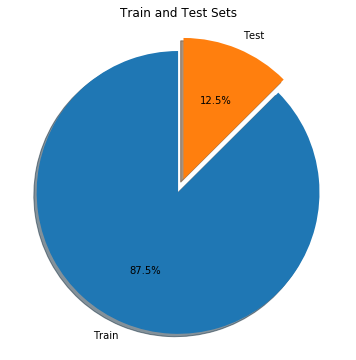

In [3]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

Explore the `train.csv` file:

In [4]:
train_df.head(10)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


`train.csv` file contains:
* __4 rows__ for each image from the train set. Each row corresponds to one of the defect labels.
* `ImageId_ClassId` is a combination of an image filename and the defect label.
* `EncodedPixels` column contains RLE encoded mask for the particular defect type or is empty, when the defect is not found.

## Explore Labels and Masks

`1` Explore empty masks:

In [5]:
print('There are {} rows with empty segmentation maps.'.format(len(train_df) - train_df.EncodedPixels.count()))

There are 43177 rows with empty segmentation maps.


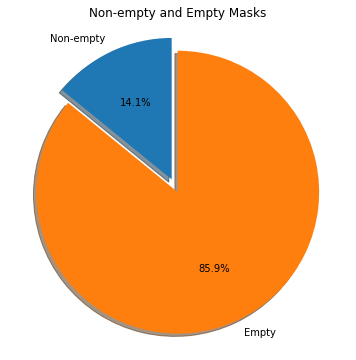

In [6]:
# plotting a pie chart
labels = 'Non-empty', 'Empty'
sizes = [train_df.EncodedPixels.count(), len(train_df) - train_df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

`2` Explore the labels:

At first, I would like to split the 1st column:

In [7]:
# split column
split_df = train_df["ImageId_ClassId"].str.split("_", n = 1, expand = True)

# add new columns to train_df
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# check the result
train_df.head()

,ImageId_ClassId,EncodedPixels,Image,Label
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


Analyse the number of labels for each defect type:

In [8]:
defect1 = train_df[train_df['Label'] == '1'].EncodedPixels.count()
defect2 = train_df[train_df['Label'] == '2'].EncodedPixels.count()
defect3 = train_df[train_df['Label'] == '3'].EncodedPixels.count()
defect4 = train_df[train_df['Label'] == '4'].EncodedPixels.count()

print('There are {} defect1 images'.format(defect1))
print('There are {} defect2 images'.format(defect2))
print('There are {} defect3 images'.format(defect3))
print('There are {} defect4 images'.format(defect4))
print('There are {} images with no defects'.format(len(train_fns) - defect1 - defect2 - defect3 - defect4))

There are 897 defect1 images
There are 247 defect2 images
There are 5150 defect3 images
There are 801 defect4 images
There are 5473 images with no defects


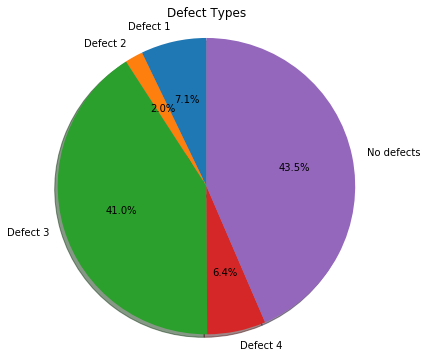

In [9]:
# plotting a pie chart
labels = 'Defect 1', 'Defect 2', 'Defect 3', 'Defect 4', 'No defects'
sizes = [defect1, defect2, defect3, defect4, len(train_fns) - defect1 - defect2 - defect3 - defect4]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')

plt.show()

__Conclusions:__
* The __dataset is very imbalanced.__
* Data augmentation and resampling techniques will be required to perform the defect detection.

In [10]:
labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 0.564528962444303


Text(0.5, 1.0, 'Number of Labels per Image')

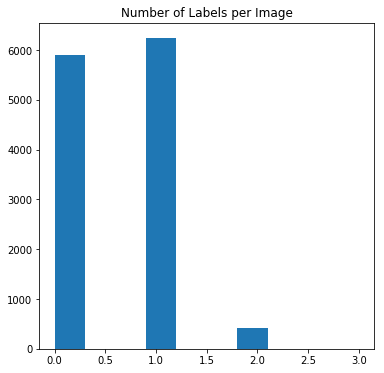

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

__Conclusions:__
* Almost half of images doesn't contain any defects;
* __Most of images with defects contain the defects of only one type__;
* In rare cases an image contains the defects of two different types.

## Analyze Images

`1.` Explore the image sizes:

In [12]:
def get_image_sizes(train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_PATH
    else:
        path = TEST_PATH
        
    widths = []
    heights = []
    
    images = sorted(glob(path + '*.jpg'))
    
    max_im = Image.open(images[0])
    min_im = Image.open(images[0])
        
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [13]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(train = False)

print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 1600
Minimum width for training set is 1600
Maximum height for training set is 256
Minimum height for training set is 256


In [14]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 1600
Minimum width for test set is 1600
Maximum height for test set is 256
Minimum height for test set is 256


__Conclusions:__
* We see that all images have the same size.

`2.` Explore masks:

Utility function to create the mask from RLE:

In [15]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

Plot image and mask:

In [16]:
def plot_mask(image_filename):
    '''
    Function to plot an image and segmentation masks.
    INPUT:
        image_filename - filename of the image (with full path)
    '''
    img_id = image_filename.split('/')[-1]
    image = Image.open(image_filename)
    train = train_df.fillna('-1')
    rle_masks = train[(train['Image'] == img_id) & (train['EncodedPixels'] != '-1')]['EncodedPixels'].values
    
    defect_types = train[(train['Image'] == img_id) & (train['EncodedPixels'] != '-1')]['Label'].values
    
    if (len(rle_masks) > 0):
        fig, axs = plt.subplots(1, 1 + len(rle_masks), figsize=(20, 3))

        axs[0].imshow(image)
        axs[0].axis('off')
        axs[0].set_title('Original Image')

        for i in range(0, len(rle_masks)):
            mask = rle2maskResize(rle_masks[i])
            axs[i + 1].imshow(image)
            axs[i + 1].imshow(mask, alpha = 0.5, cmap = "Reds")
            axs[i + 1].axis('off')
            axs[i + 1].set_title('Mask with defect #{}'.format(defect_types[i]))

        plt.suptitle('Image with defect masks')
    else:
        fig, axs = plt.subplots(figsize=(20, 3))
        axs.imshow(image)
        axs.axis('off')
        axs.set_title('Original Image without Defects')

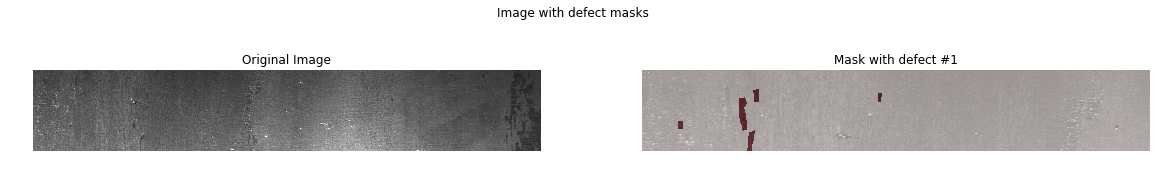

In [17]:
# plot image with single defect
plot_mask(train_fns[0])

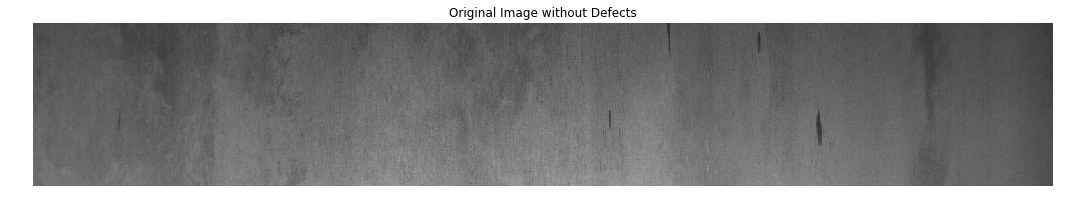

In [18]:
# plot image without defects
plot_mask(train_fns[1])

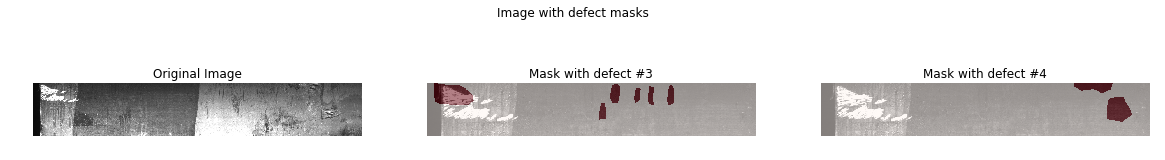

In [37]:
# plot image example with several defects
for image_code in train_df.Image.unique():
    if (train_df.groupby(['Image'])['EncodedPixels'].count().loc[image_code] > 1):
        plot_mask(TRAIN_PATH + image_code)
        break;